<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Andrea Flores Fernández y Tania Bell Nicholls.

**Fecha:** 09 de octubre del 2021.

**Expediente** : IF725449 y IF716767.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Tania-Bell/Proyecto_TBell_AFlores.git

# Proyecto Simulación - Censo de Ingresos

## Descripción

> Nuestro dataset contiene las mediciones de 4 meses con diferentes variables que nos ayudan a predecir el nivel de radiación solar. Predecir la radiación solar es importante ya que es la fuente de energía mas importante de la tierra y tiene efectos balance de radiación en la superficie, ciclos hidrológicos, fotosíntesis, condiciones meteorológicas y climas extremos.  



## Objetivos

> #### Objetivo General:
Obtener la probabilidad de una alta radiación solar 

> #### Objetivo específico:
    > - 
    > - 
    > - 
    > - 

## Definición del Problema



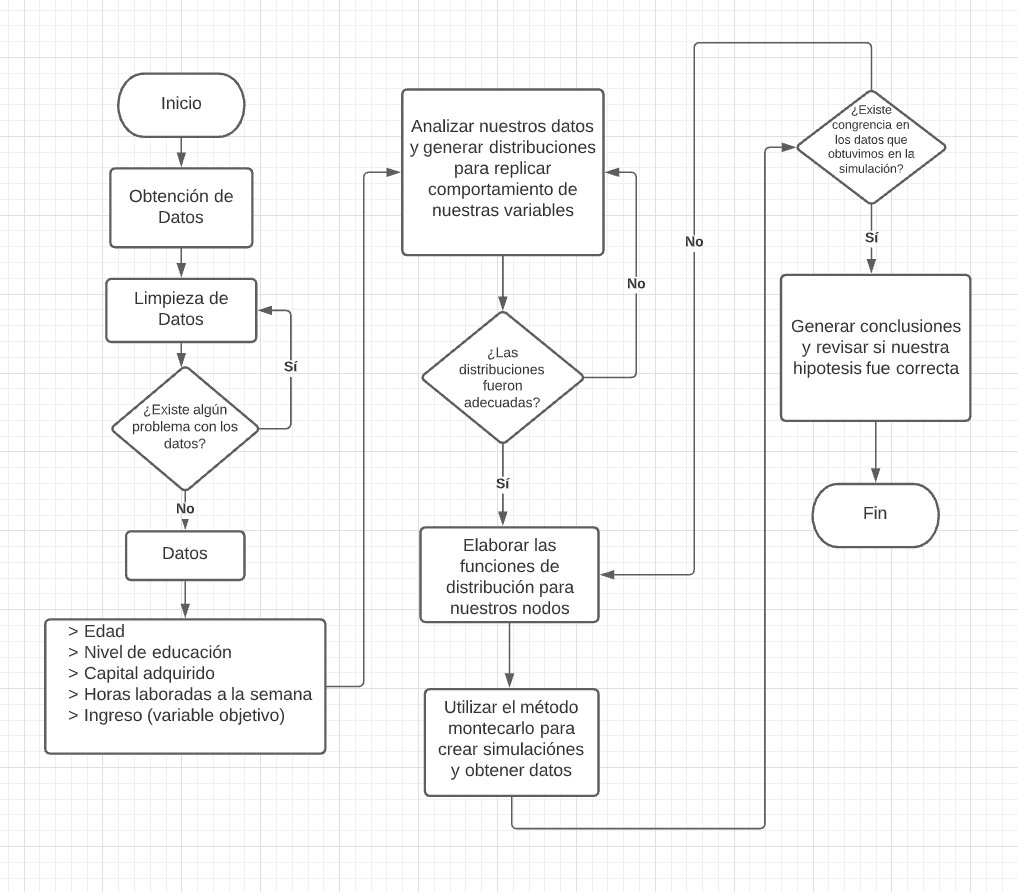

## Nodos y variables que se decidieron simular y por qué

>Para desarrollar el proyecto tomamos las siguientes variables:
    > - Temperatura: 
    > - Presión: 
    > - Humedad:
    > - Velocidad:


## Definición de hipótesis y supuestos



## Obtención de bases de datos

> Nuestro dataset fue proporcionado por la NASA y lo obtuvimos de una publicación en Kaggle 

> https://www.kaggle.com/dronio/SolarEnergy/version/1

In [1]:
# importación de las librerías
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm 
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import warnings
warnings.filterwarnings("ignore")

In [8]:
# importación de los datos, el archivo está en un csv y se llama adult
data = pd.read_csv('SolarPrediction.csv')
#data = data[['age','educational-num','capital-gain','hours-per-week']].head(20001)
data

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


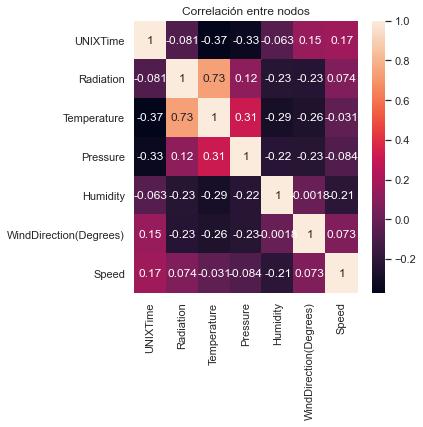

In [16]:
# análisis de correlación entre los datos
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True, linewidths=.0001)
sn.set(rc = {'figure.figsize':(5,5)})
plt.title('Correlación entre nodos') # generación de tabla
plt.show()

interpretación: 

## Visualización de Variables

Para generar una idea general de nuestros datos, los visualizaremos usando histogramas. Nos mostrará, a primera vista, si hay una distribución obvia en nuestros nodos.

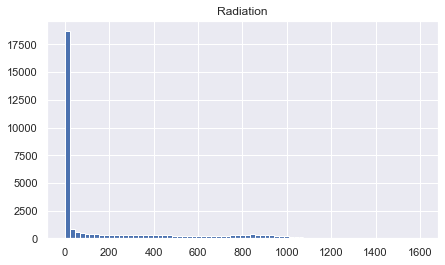

In [20]:
# histograma para visualizar la Radiación 
plt.figure(figsize=(7,4))
plt.hist(data['Radiation'], bins = 'auto');
plt.title('Radiation');

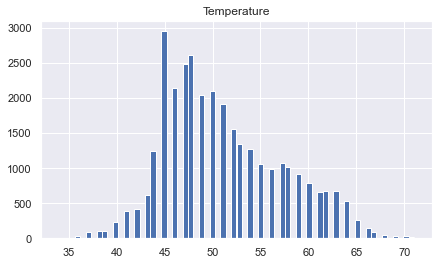

In [21]:
# histograma para visualizar la variable temperatura 
plt.figure(figsize=(7,4))
plt.hist(data['Temperature'], bins = 'auto');
plt.title('Temperature');

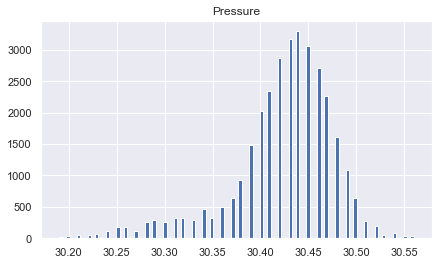

In [22]:
# histograma con 40 bins para visualizar la variable presión 
plt.figure(figsize=(7,4))
plt.hist(data['Pressure'], bins = 'auto');
plt.title('Pressure');

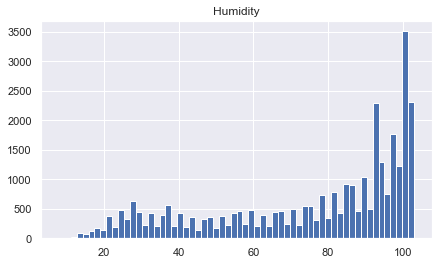

In [12]:
# histograma para visualizar la variable humedad 
plt.figure(figsize=(7,4))
plt.hist(data['Humidity'], bins = 60);
plt.title('Humidity');

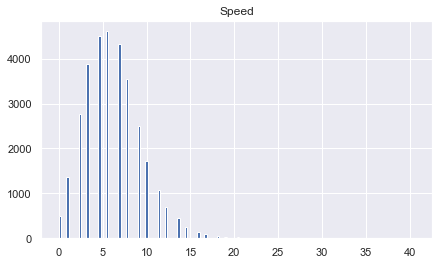

In [24]:
# histograma para visualizar la variable velocidad
plt.figure(figsize=(7,4))
plt.hist(data['Speed'], bins = 'auto');
plt.title('Speed');

## Funciones

In [25]:
def kde_sklearn(x:'X, nodo', x_grid:'generación de números en intervalo', bandwidth:'bandwidth óptimo', **kwargs:'especificaciones'):
    '''
    Kernel Density Estimation with Scikit-learn
    '''
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


def distribuciones(data:'Nodo'):
    '''
    Iteración con las diferentes distribuciones. Retorna el plot con las distribuciones y tabla de error
    '''
    #generación de iteración de distribuciones en st, sólo las continuas
    rv_continuas = [d_i for d_i in dir(st) if isinstance(getattr(st, d_i), getattr(st, 'rv_continuous'))]

    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    #crea la tabla de errores por ditribución iterada
    error = pd.DataFrame(columns=['Distribución', 'Error'])
    i = 0
    y, x, _ = ax.hist(data, bins=50, density=True)
    x = x[1:]
    #se ejecuta la iteración
    for d_i in rv_continuas[20:30] + ['beta']:
        try:
            params = getattr(st, d_i).fit(data)
            data_hat = getattr(st, d_i).pdf(x, *params) # usando probability distribution function
            ax.plot(x, data_hat, label=d_i)
            error.loc[i, :] = [d_i, np.mean((y - data_hat)**2)]
            i += 1
        except ValueError:
            pass

    plt.legend()
    error.set_index('Distribución', inplace=True)
    error.sort_values('Error', inplace=True)
    return error

def pruebaq_q(data:'Nodo', dist:'Distribución óptima'):
    '''
    Prueba Q_Q, genera gráfica con la distribución y la gráfica Q_Q (45 grados)
    '''
    # Histograma de las variables creadas
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    fig.tight_layout(pad=3.0)
    # distribuciones y prueba
    y, x, _ = ax[0].hist(data, 50, density=True, label='Histograma')
    params = getattr(st, dist).fit(data)
    y_hat = getattr(st, dist).pdf(x, *params) # usando probability distribution function
    # creación de gráficas
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probabilidad')
    ax[0].grid()
    grafica = st.probplot(data, dist=dist, sparams=getattr(st, dist).fit(x)[:-2], plot=ax[1], fit=True)
    ax[1].grid()
    ax[1].set_title('Scipy')
    plt.show()
    
def red_var(data:'Nodo', N:'Número para muestra',f:'Pdf', t:'Función lambda', model:'Model'):
    '''
    Reducción de Varianza y Montecarlo, retorna las variables aceptadas
    '''
    # parámetros y generación de variables
    r1 = muestra_est(N) # usando función del muestreo estratificado
    np.random.shuffle(r1)
    ct = 0
    i = 0
    var_acept = np.zeros(1000)
    # iteración de aceptación o rechazo
    while ct < 1000:    
        r = np.random.uniform(min(data), max(data), 1)
        f_x = f(r, model)
        t_x = t(r)
        condition = r1[i] * t_x <= f_x
        if condition[0]:
            var_acept[ct] = r[0]
            ct += 1
        i+=1
    return var_acept

def pdf(x:'x_grid, intervalo', model:'Model'):
    '''
    Pdf para reducción de varianza
    '''
    return np.exp(model.score_samples(x.reshape(-1, 1)))

def muestra_est(n:'Número de muestras'):
    '''
    Muestreo Estratificado
    '''
    # generación de variables aleatorias entre 0 y 1
    u = np.random.uniform(0, 1, n)
    i = np.arange(0, n)
    return (u + i) / n

def kolmogorov(data:'Nodo',dist:'Distribución Óptima'):
    '''
    Prueba Kolmogorov-Smirnov
    '''
    param = getattr(st, dist).fit(data)
    return st.kstest(data, dist, args = (param))

def chi_cuadrada(dist:'Distribución Óptima', data:'Nodo', x:'x', y:'y', J1:'Bins', c:'Confianza'):
    '''
    Prueba de Chi cuadrada, genera el teórico, el de la librería, el estadístico y arroja media y desviación estándar
    '''
    # parámetros
    param = getattr(st, dist).fit(data)
    pi = getattr(st, dist).pdf(x, *param) # usando probability distribution function
    
    Ei = x*pi

    x2 = np.sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y))) # teórico
    print('Chi cuadrado teórico: ', x2)

    X2 = st.chisquare(y, Ei) # usando librería scipy.stats
    print('Chi cuadrado stats: ', X2)

    p = len(param) 
    m = J1-p-1 
    
    Chi_est = st.chi2.ppf(q=c, df=m) # estadístico
    print('Estadístico de chi_cuadrado: ', Chi_est)
    
    mu = np.mean(x) # media
    sigma = np.std(x) # desviación estándar
    print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

## Procedimiento de la simulación:

>Primero, generaremos box-plots para visualizar los outliers y poderlos eliminar para tener datos más uniformes. Luego, implementaremos algunos métodos como logaritmo o raíz cuadrada para ajustar los datos. Como tercer paso, encontraremos el bandwidth adecuado para cada nodo y posteriormente realizaremos el método de KDE usando la librería Scikit-learn. Después realizaremos el método de reducción de varianza usando aceptación y rechazo. Luego simularemos con varias distribuciones para ver cuál es la más adecuada para cada nodo. Usando la distribución con menor error, realizaremos la prueba Q_Q, kolmogorov y chi cuadrada. 

## Nodo 1: Temperatura 

#### Box-Plots y Ajuste de datos

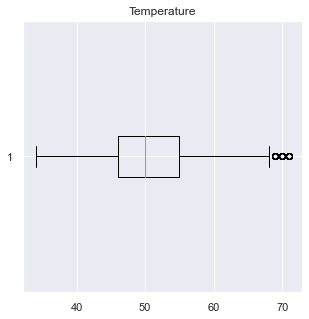

In [27]:
temp = np.array(data['Temperature'])
plt.boxplot(temp,vert=False)
plt.title('Temperature')
plt.show() #mostramos boxplot e identificamos outliers 

In [32]:
temp = np.log(temp[temp>0])
temp = temp[~np.isnan(temp)]
temp #aplicamos una transformación logaritmica para ver si mejora la distribución de nuestros datos 

array([0.6767824 , 0.6767824 , 0.6767824 , ..., 0.66541588, 0.66541588,
       0.66541588])

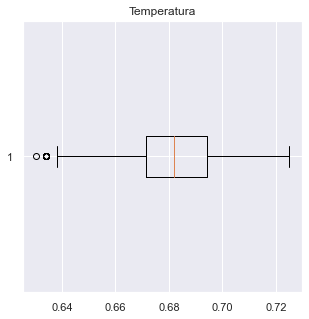

In [33]:
plt.boxplot(temp,vert=False)
plt.title('Temperatura')
plt.show()

#### Bandwidth Óptimo

In [36]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 10)},
                    cv=10) # 15-fold cross-validation
grid.fit(temp[:, None])


GridSearchCV(cv=10, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])})

In [37]:
print(grid.best_params_) # usando KDE encontramos un bandwith para el mejor ajuste de nuestros datos 

{'bandwidth': 0.1111111111111111}


#### KDE

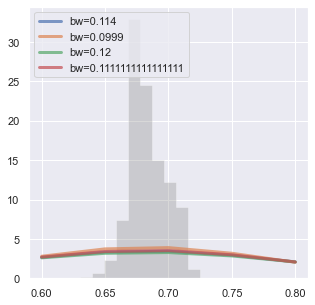

In [46]:
fig, ax = plt.subplots() 
for bandwidth in [0.114, 0.0999, .12, 0.1111111111111111]:
    ax.plot(np.linspace(.6,.8,5), kde_sklearn(temp, np.linspace(.6,.8,5), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(temp, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left') # vemos en el grafico el ajuste de los datos usando diferentes bw y vemos como funciona el que nos arrojo 

#### Reducción de Varianza y Montecarlo

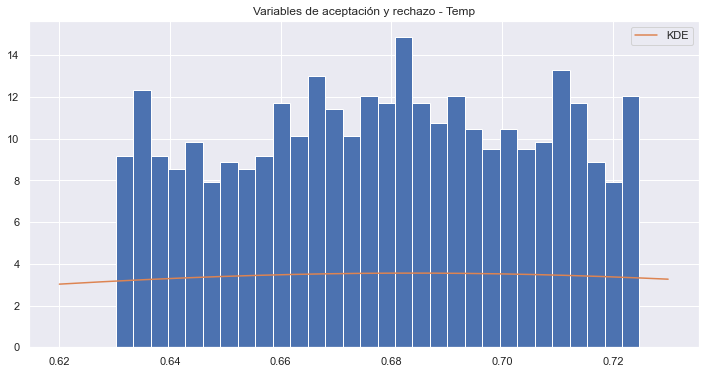

In [50]:
model = KernelDensity(bandwidth=0.1111111111111) #usando bandwidth óptimo
model.fit(temp.reshape(-1, 1))
x_grid = np.linspace(.62, .73, 10000)
pdf_temp = pdf(x_grid[:, None], model) # usando función pdf

plt.figure(figsize=(12,6))
var_aleatorias = red_var(temp,1000*5,pdf, lambda x: max(pdf_temp) * np.ones(len(x)), model) # usand pdf

plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_temp, alpha=1, label='KDE') # graficamos
plt.title('Variables de aceptación y rechazo - Temp')
plt.legend()
plt.show()

#### Distribuciones

,Error
Distribución,
exponweib,87.369683
fisk,87.416462
fatiguelife,87.540912
gamma,87.551129
f,87.578593
genextreme,87.644684
beta,88.630357
foldcauchy,98.428683
genexpon,165.50287


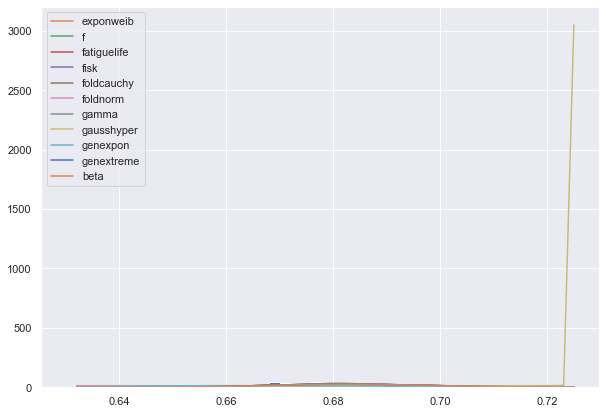

In [51]:
distribuciones(temp) # la mejor distribución fue exponweib para el nodo temperatura 

#### Prueba Q_Q

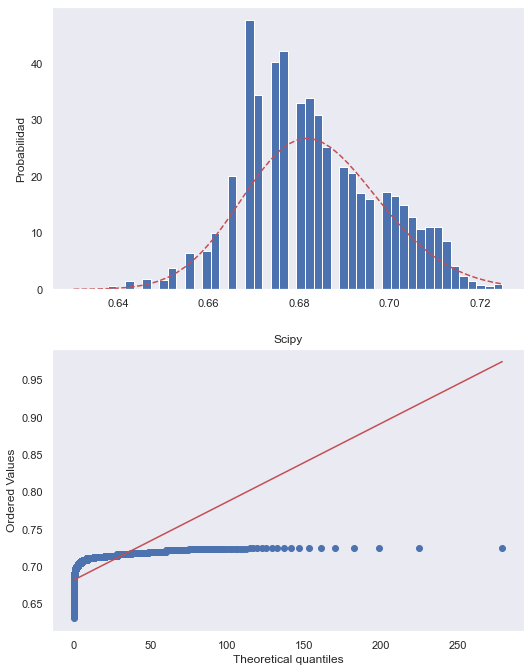

In [53]:
pruebaq_q(temp,'exponweib') # llama la función para hacer la prueba de 45 grados 

#### Prueba Kolmogorov-Smirnov

In [54]:
kolmogorov(temp,'exponweib') # hacemos prueba de kolmogrov 

KstestResult(statistic=0.07368108957475267, pvalue=9.201852889243865e-155)

#### Prueba Chi Cuadrada

Chi cuadrado teórico:  150.96506366014023
Chi cuadrado stats:  Power_divergenceResult(statistic=150.96506366014023, pvalue=1.9494966511180728e-18)
Estadístico de chi_cuadrado:  37.65248413348277
Media muestral =  0.6791213562550715 
Desviación estándar muestral =  0.027355770154197327


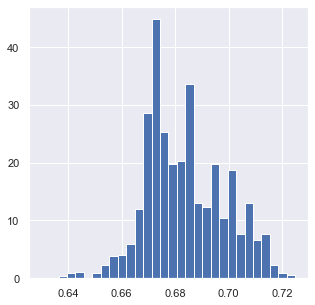

In [55]:
J1 = 30
y, x, _ = plt.hist(temp, bins = J1, density = True)
x = x[1:]
chi_cuadrada('exponweib',temp,x,y,J1,0.95) # aplicamos la prueba de chi cuadrada 

## Nodo 2: Presión

#### Box-Plots y Ajuste de datos

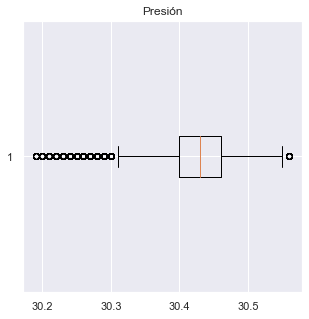

In [57]:
pres = np.array(data['Pressure'])
plt.boxplot(pres,vert=False)
plt.title('Presión')
plt.show() # sacamos boxplot para ver la distribución de nuestros datos

In [58]:
pres = np.sqrt(pres[pres>0])
pres = pres[~np.isnan(pres)]
pres # aplicamos una transformación de raiz cuadrada para mejorar la distribución de nuestros datos

array([5.51905789, 5.51905789, 5.51905789, ..., 5.51543289, 5.51543289,
       5.51633937])

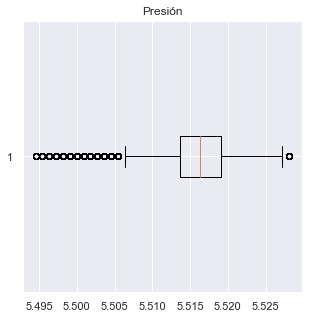

In [60]:
plt.boxplot(pres,vert=False)
plt.title('Presión')
plt.show() # usamos showfliers para eliminar los outliers ya que la transformación no fue suficiente 

#### Bandwidth Óptimo

In [71]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 10)},
                    cv=10) # 15-fold cross-validation
grid.fit(pres[:, None]) 

GridSearchCV(cv=10, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])})

In [72]:
print(grid.best_params_) #encontramos el bw ideal para el KDE 

{'bandwidth': 0.1111111111111111}


#### KDE

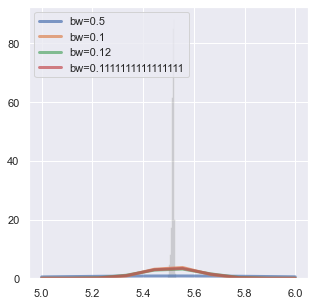

In [118]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.1111111111111111]:
    ax.plot(np.linspace(5,6,10), kde_sklearn(pres, np.linspace(5,6,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(pres, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left') #vemos como se ajustan a nuestro datos 

#### Reducción de Varianza y Montecarlo

In [81]:
model = KernelDensity(bandwidth=0.1111111111111) #usando bandwidth óptimo
model.fit(pres.reshape(-1, 1))
x_grid = np.linspace(.62, .73, 10000)
pdf_pres = pdf(x_grid[:, None], model) # usando función pdf

plt.figure(figsize=(12,6))
var_aleatorias = red_var(pres,1000*5,pdf, lambda x: max(pdf_pres) * np.ones(len(x)), model) # usand pdf

plt.hist(var_aleatorias, 30, density=True)

plt.plot(x_grid, pdf_pres, alpha=1, label='KDE') # graficamos
plt.title('Variables de aceptación y rechazo - Temp')
plt.legend()
plt.show()

TypeError: 'numpy.float64' object is not callable

<Figure size 864x432 with 0 Axes>

#### Distribuciones

,Error
Distribución,
fisk,860.206507
beta,887.971604
genextreme,990.239186
foldnorm,1007.256952
f,1016.081275
fatiguelife,1022.700934
gamma,1092.399941
genexpon,1881.387157
foldcauchy,2564.96289


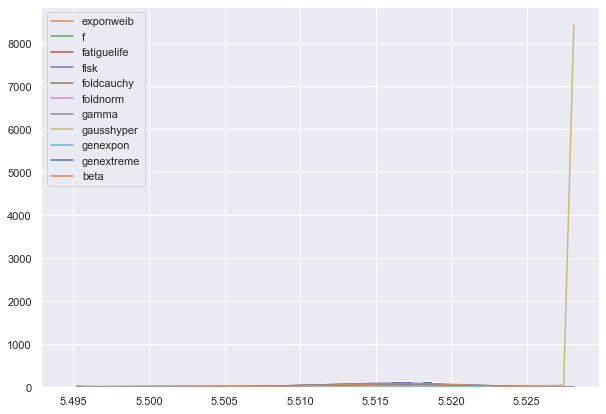

In [83]:
distribuciones(pres)

#### Prueba Q_Q

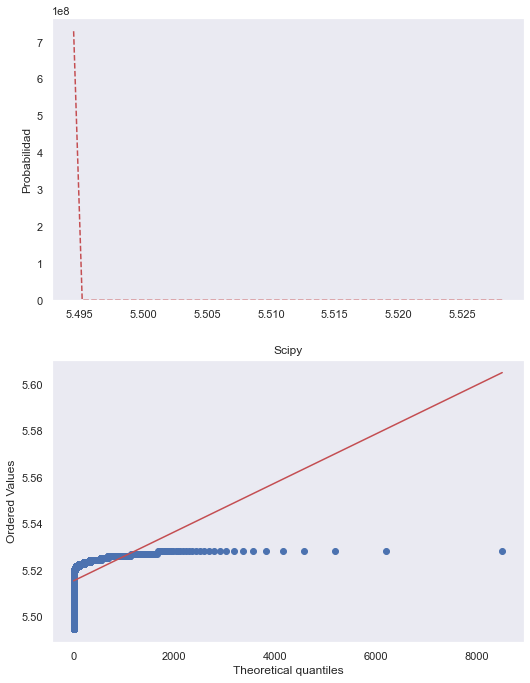

In [85]:
pruebaq_q(pres,'exponweib') # a pesar de la funcion de distribución recomienda expoinweb probando con otras la mejor se ajusto fue foldcauchy 

#### Prueba Kolmogorov-Smirnov

In [86]:
kolmogorov(pres,'foldcauchy') # prueba de kolmogrov 

KstestResult(statistic=0.45075142780370525, pvalue=0.0)

#### Prueba Chi Cuadrada

Chi cuadrado teórico:  1328.6511492770885
Chi cuadrado stats:  Power_divergenceResult(statistic=1328.6511492770885, pvalue=1.716512231718505e-261)
Estadístico de chi_cuadrado:  38.885138659830055
Media muestral =  5.51188581973541 
Desviación estándar muestral =  0.00968464190335995


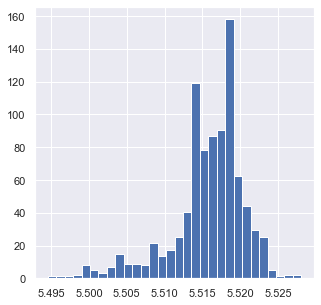

In [87]:
J1 = 30
y, x, _ = plt.hist(pres, bins = J1, density = True)
x = x[1:]
chi_cuadrada('foldcauchy',pres,x,y,J1,0.95) # prueba de chicuadrada 

#### Humedad 

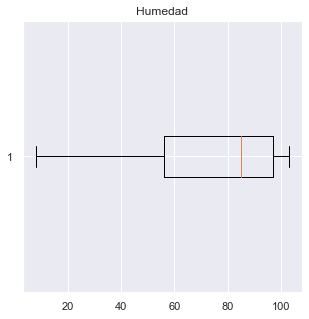

In [90]:
hume = np.array(data['Humidity'])
plt.boxplot(hume,vert=False)
plt.title('Humedad')
plt.show()

In [92]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 10)}, 
                    cv=10) # 15-fold cross-validation
grid.fit(hume[:, None])

GridSearchCV(cv=10, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])})

In [93]:
print(grid.best_params_)

{'bandwidth': 0.1111111111111111}


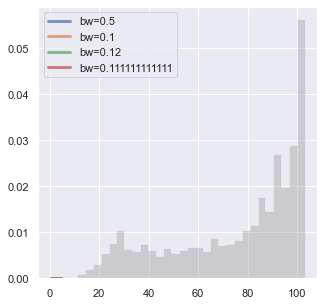

In [96]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.111111111111]:
    ax.plot(np.linspace(0.5,4.5,10), kde_sklearn(hume, np.linspace(0.5,4.5,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(hume, 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

,Error
Distribución,
foldcauchy,0.000084
exponweib,0.000094
fisk,0.000108
f,0.000111
fatiguelife,0.000112
gamma,0.000114
genexpon,0.000128
foldnorm,0.000197
genextreme,0.000779


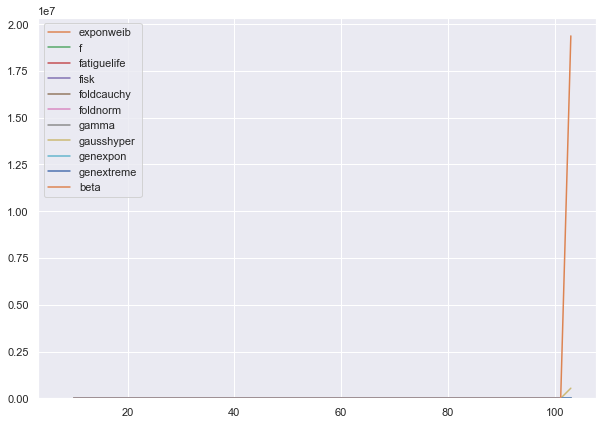

In [97]:
distribuciones(hume)

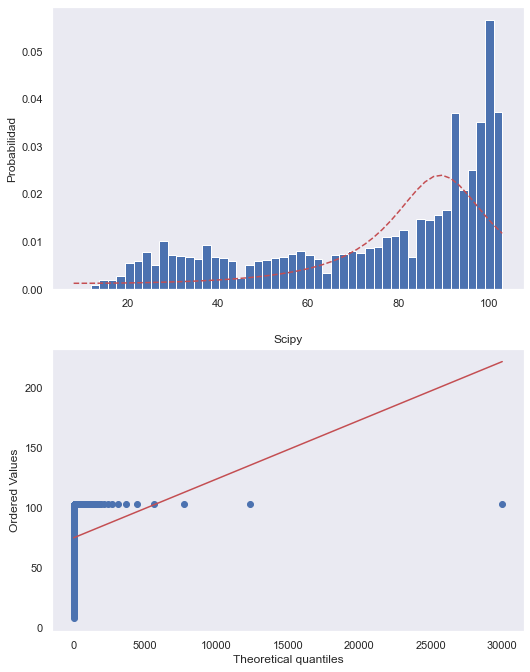

In [99]:
pruebaq_q(hume,'foldcauchy')

In [101]:
kolmogorov(hume,'foldcauchy') # prueba de kolmogrov 

KstestResult(statistic=0.27599151613601514, pvalue=0.0)

Chi cuadrado teórico:  18.183635894295747
Chi cuadrado stats:  Power_divergenceResult(statistic=18.183635894295747, pvalue=0.9404442324290616)
Estadístico de chi_cuadrado:  38.885138659830055
Media muestral =  57.083333333333336 
Desviación estándar muestral =  27.408897919930766


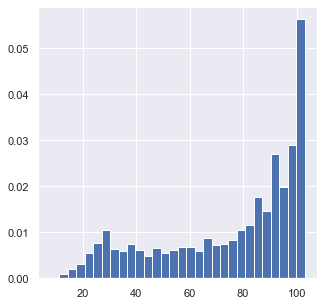

In [102]:
J1 = 30
y, x, _ = plt.hist(hume, bins = J1, density = True)
x = x[1:]
chi_cuadrada('foldcauchy',hume,x,y,J1,0.95) # prueba de chicuadrada 

#### Capital Adquirido

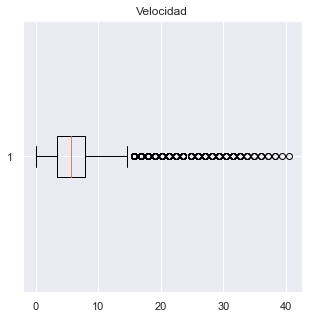

In [103]:
velo = np.array(data['Speed'])
plt.boxplot(velo,vert=False)
plt.title('Velocidad')
plt.show()

In [107]:
velo = np.sqrt(velo[velo>0])
velo = velo[~np.isnan(velo)]
velo

array([0.73891727, 0.44121679, 0.44121679, ..., 0.88724011, 0.85099317,
       0.44121679])

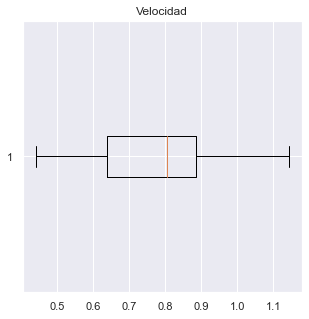

In [108]:
plt.boxplot(velo,vert=False)
plt.title('Velocidad')
plt.show()

In [109]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 1, 15)},
                    cv=15) # 15-fold cross-validation
grid.fit(velo[:, None])

GridSearchCV(cv=15, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])})

In [110]:
print(grid.best_params_)

{'bandwidth': 0.07142857142857142}


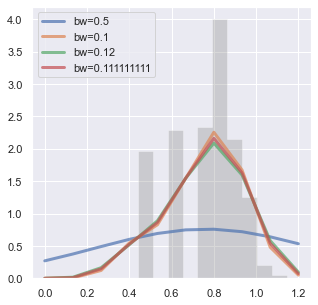

In [117]:
fig, ax = plt.subplots()
for bandwidth in [0.5, 0.1, 0.12, 0.111111111]:
    ax.plot(np.linspace(0,1.2,10), kde_sklearn(velo, np.linspace(0,1.2,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(velo, 10, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

,Error
Distribución,
foldcauchy,10.062387
fisk,10.163979
foldnorm,10.177387
f,10.245685
fatiguelife,10.247868
gamma,10.307999
genexpon,10.686004
gausshyper,10.791906
exponweib,10.798659


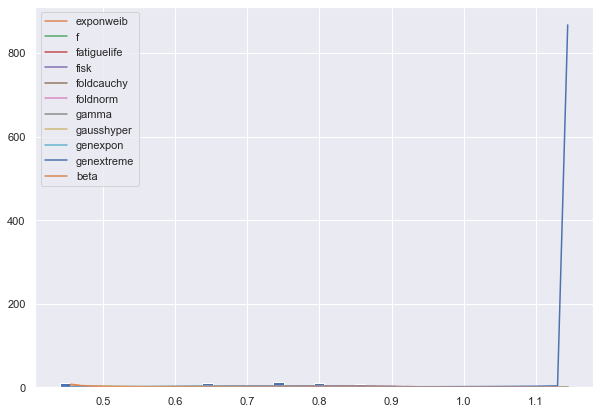

In [112]:
distribuciones(velo)

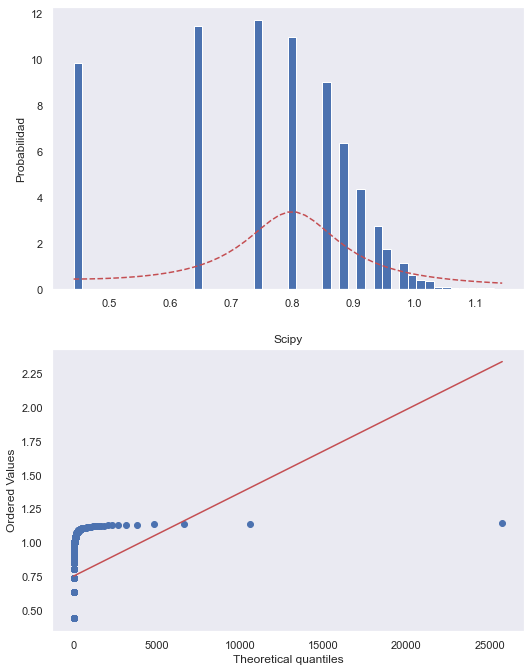

In [113]:
pruebaq_q(velo,'foldcauchy')

In [114]:
kolmogorov(velo,'foldcauchy') # prueba de kolmogrov 

KstestResult(statistic=0.18888559061544935, pvalue=0.0)

Chi cuadrado teórico:  5427470.031091446
Chi cuadrado stats:  Power_divergenceResult(statistic=5427470.031091446, pvalue=0.0)
Estadístico de chi_cuadrado:  38.885138659830055
Media muestral =  5.51188581973541 
Desviación estándar muestral =  0.00968464190335995


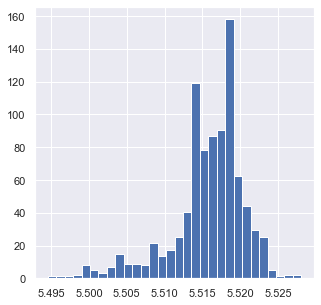

In [115]:
J1 = 30
y, x, _ = plt.hist(pres, bins = J1, density = True)
x = x[1:]
chi_cuadrada('foldcauchy',velo,x,y,J1,0.95) # prueba de chicuadrada 

### Visualización de resultados de simulación

### Conclusiones

## Conclusiones primeros 2 Nodos

En ambos casos nos damos cuenta que con nuestros datos ajustados podemos encontrar distribuciones que pueden representar correctamente nuestros datos, lo que nos da cierta confianza de que tenemos buenas aproximaciones. Para llegar a esto fue necesario encontrar una transformación adecuada para nuestros datos y en el segundo caso eliminar los outliers que todavia se mostraban en el boxplot. Después encontramos el bandwith adecuado para nuestro KDE, para despues usar el método de varianza y despues montecarlo modelando nuestros datos. Con esto buscamos una distribución adecuada para nuestros datos y usamos la que mejor se ajustara para realizar diferentes pruebas de nuestras distribución (Chi cuadrada, kolmogrov,) con los gráficos y los datos arrojados nos damos cuenta que aun pueden exisistir mejores distribuciones pero las que tenemos muestran buenos resultados 


### Referencias

T.T.B. (2021, 4 agosto). Medical Insurance Premium Prediction. Recuperado 9 de octubre de 2021, de https://www.kaggle.com/tejashvi14/medical-insurance-premium-prediction